In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,24565.601562,41358451255
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,24641.277344,19625427158
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,24327.642578,25555105670


In [3]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2981 entries, 2014-12-25 to 2023-02-21
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2981 non-null   float64
 1   High       2981 non-null   float64
 2   Low        2981 non-null   float64
 3   Adj Close  2981 non-null   float64
 4   Volume     2981 non-null   int64  
 5   RSI        2981 non-null   float64
 6   EMA_short  2981 non-null   float64
 7   EMA_long   2981 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.6 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911
2023-02-16,24307.349609,25134.117188,23602.523438,23623.474609,39316664596,61.025952,22569.804919,20326.590628
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,41358451255,65.990173,22759.880790,20410.531439
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,19625427158,66.358943,22939.061414,20494.308585
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,25555105670,63.310636,23071.307239,20570.216189
2023-02-20,24336.623047,25020.458984,23927.910156,24829.148438,28987376573,65.987423,23238.720687,20654.551481


In [4]:
"""# Split data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]"""
    
# Split the data into training and test sets
train_data  = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]


In [5]:
train_x = train_data.index
train_y = train_data['Adj Close']
test_x = test_data.index
test_y = test_data['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='Train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title ='Train and Test Bitcoin Data',
    font_size=15,
    font_color='black',
    legend_title_text=' Parameters'
)

fig.show()

In [6]:
print ('Train shape',train_data.shape)
print ('test shape', test_data.shape)

Train shape (2384, 8)
test shape (597, 8)


In [7]:

scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)



In [8]:
# Prepare the training data
X_train = np.array([train_data[i:i+1] for i in range(len(train_data)-1)])
y_train = train_data[1:]
#y_train = np.array([train_data.iloc[i+1] for i in range(len(train_data)-1)])
# Prepare the testing data 
X_test = np.array([test_data[i:i+1] for i in range(len(test_data)-1)])
y_test = test_data[1:]
#y_test = np.array([test_data.iloc[i+1] for i in range(len(test_data)-1)])

In [9]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 

X_train (2383, 1, 8)
y_train (2383, 8)
X_test (596, 1, 8)
Y_test (596, 8)


In [10]:
# Normalize the data
"""mean = train_data.mean()
std = train_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std"""


'mean = train_data.mean()\nstd = train_data.std()\ntrain_data = (train_data - mean) / std\ntest_data = (test_data - mean) / std'

In [11]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43600     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [12]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
75/75 [==============================] - 22s 17ms/step - loss: 0.0544 - accuracy: 0.8938 - mean_absolute_error: 0.1432
Epoch 2/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.0220 - accuracy: 0.9219 - mean_absolute_error: 0.1000
Epoch 3/1000
75/75 [==============================] - 1s 18ms/step - loss: 0.0126 - accuracy: 0.9274 - mean_absolute_error: 0.0745
Epoch 4/1000
75/75 [==============================] - 2s 22ms/step - loss: 0.0099 - accuracy: 0.9270 - mean_absolute_error: 0.0636
Epoch 5/1000
75/75 [==============================] - 1s 20ms/step - loss: 0.0094 - accuracy: 0.9287 - mean_absolute_error: 0.0596
Epoch 6/1000
75/75 [==============================] - 1s 20ms/step - loss: 0.0078 - accuracy: 0.9282 - mean_absolute_error: 0.0544
Epoch 7/1000
75/75 [==============================] - 2s 20ms/step - loss: 0.0074 - accuracy: 0.9295 - mean_absolute_error: 0.0525
Epoch 8/1000
75/75 [==============================] - 2s 20ms/step - loss: 0.0066 

In [26]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16,5))
 
    plt.plot(history['mean_absolute_error'])
    plt.legend([ 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
 
    plt.plot(history['loss'])
    plt.legend([ 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))

    plt.plot(history['accuracy'])
    plt.legend([ 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()




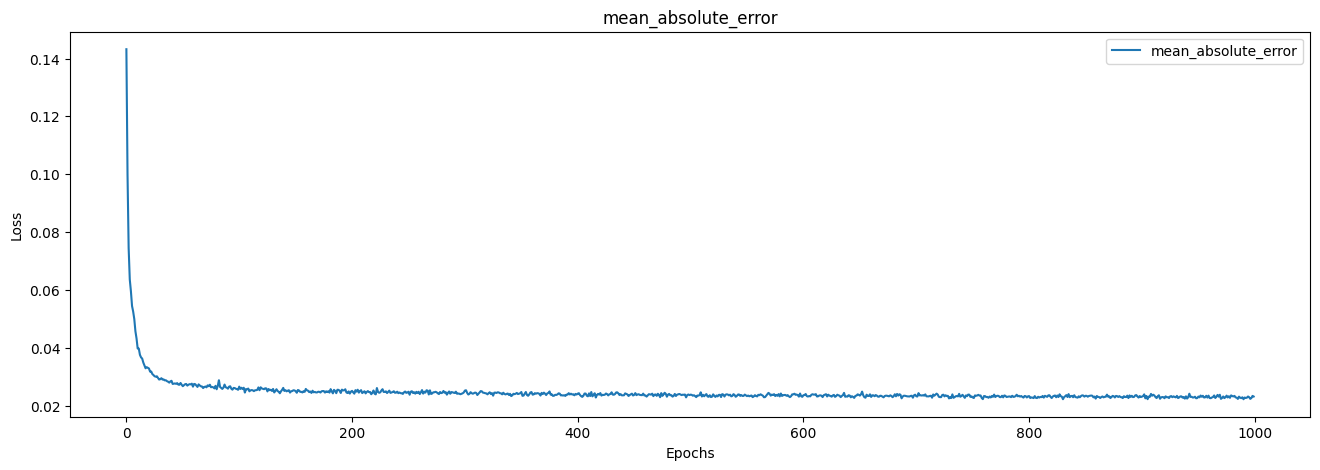

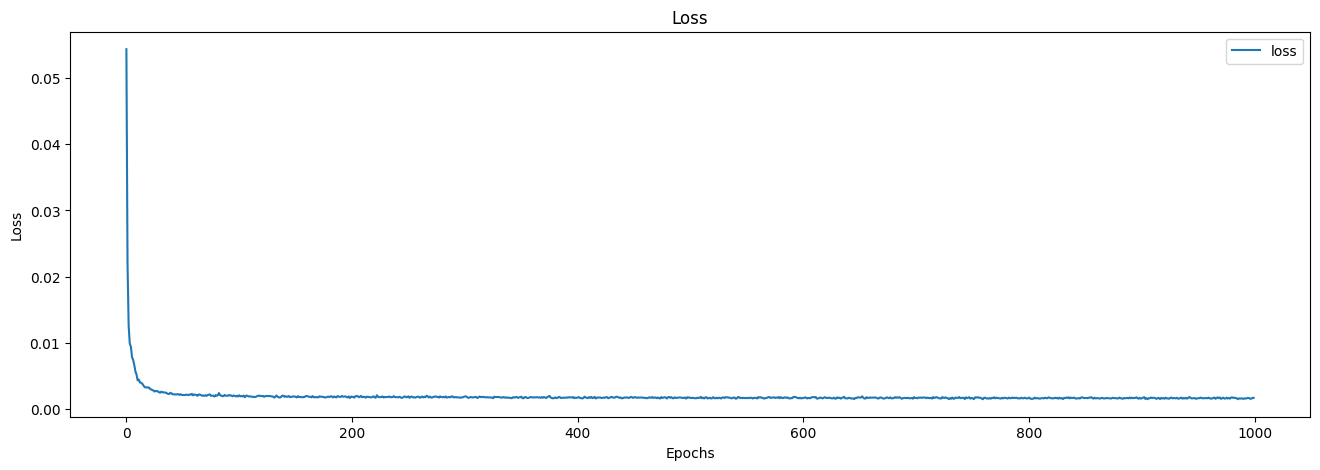

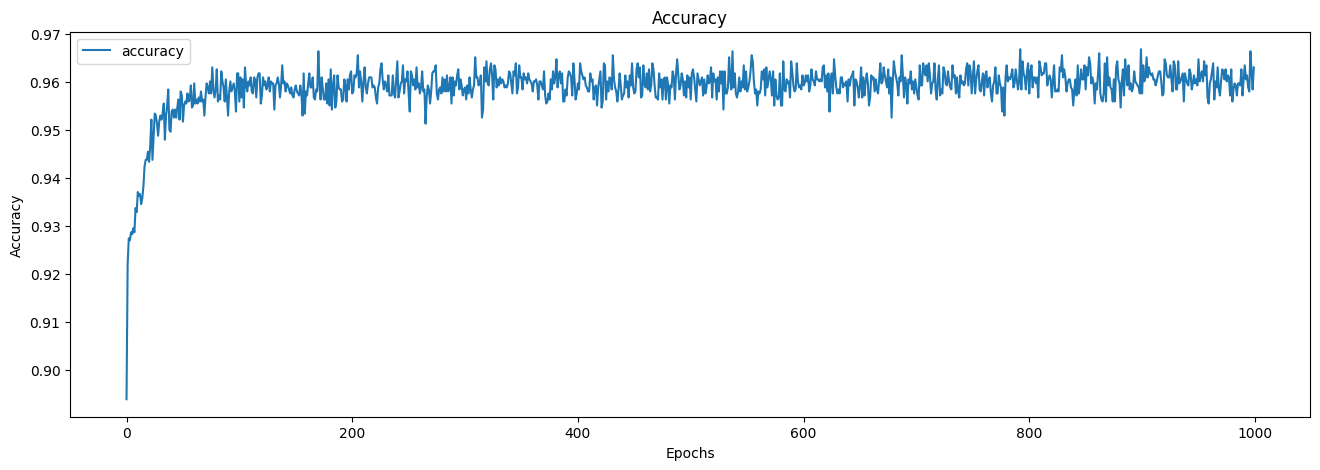

In [27]:
visualize_training_results(history)

In [28]:
mean_squared_error,accuracy ,mean_absolute_error = model.evaluate(X_test, y_test)


19/19 [==============================] - 0s 9ms/step - loss: 131698526408683814912.0000 - accuracy: 0.0000e+00 - mean_absolute_error: 3807301632.0000


In [29]:
# Make predictions on the test data
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 7ms/step


In [30]:
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)

y_pred (596, 8)
y_test (596, 8)


In [31]:
# convert to original data 
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [32]:
print (y_pred)
print ('-------------------------------------------------------------')
print (y_test)


[[34591.434    35765.652    33068.67     ...    42.38896  37239.754
  40656.273   ]
 [34613.79     35787.355    33093.574    ...    42.549557 37211.816
  40549.938   ]
 [34574.777    35747.703    33054.34     ...    42.466106 37198.9
  40583.105   ]
 ...
 [26586.078    27485.998    25638.92     ...    69.237335 24090.527
  18374.54    ]
 [26540.443    27428.957    25585.45     ...    65.25037  24358.691
  18792.271   ]
 [26735.514    27637.96     25780.787    ...    68.36256  24296.807
  18571.12    ]]
-------------------------------------------------------------
[[2.13627840e+09 2.26528940e+09 2.08445357e+09 ... 3.84689099e+03
  2.06925951e+09 2.11123491e+09]
 [2.16808941e+09 2.26264702e+09 2.09930354e+09 ... 3.76455656e+03
  2.06384238e+09 2.10366866e+09]
 [2.14680017e+09 2.19219269e+09 1.99346110e+09 ... 3.55474363e+03
  2.05340495e+09 2.09526316e+09]
 ...
 [1.56086846e+09 1.62230049e+09 1.50922520e+09 ... 5.27499845e+03
  1.37137149e+09 1.05061080e+09]
 [1.54164875e+09 1.61760708e+

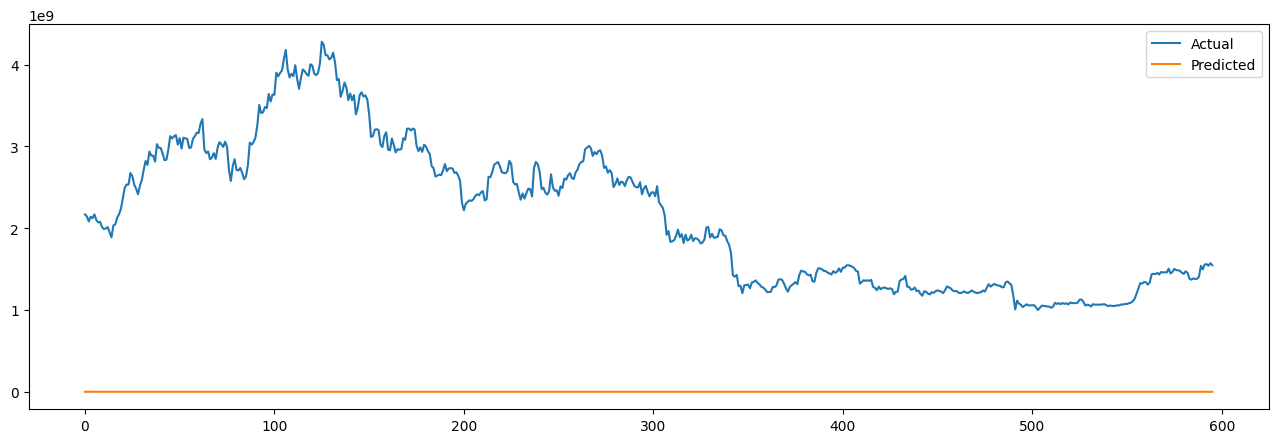

In [33]:
# Combine the two dataframes and plot the results

plt.figure(figsize=(16,5))
plt.plot(y_test[:,3], label="Actual")
plt.plot(y_pred[:,3], label="Predicted")
plt.legend()
plt.show()

In [34]:
# Compute the evaluation metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))

print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 99.85%
MSE: 16221700134281564921733257443766616362844160.00
RMSE: 4027617178218601119744.00
MAE: 1336201769886320164864.00


In [22]:
# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE:", rmse)

# Calculate the MSE (Mean Squared Error)
mse = np.mean((y_test - y_pred) ** 2)
print("MSE:", mse)

# Calculate the MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_test- y_pred))
print("MAE:", mae)


MAPE: 17.561568483977492
RMSE: 8818133775.043978
MSE: 7.775948327457137e+19
MAE: 2638676514.772581


In [23]:
print( X_test.shape)

(596, 1, 8)


In [24]:

# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array([test_data[-30:]])
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:],  [prediction[np.newaxis,:]], axis=1)


1/1 [==============================] - 0s 71ms/step


In [25]:
# Convert the predictions back to actual Bitcoin prices
predictions = np.array(predictions) * std.values + mean.values


NameError: name 'std' is not defined

In [ ]:
test_data= np.array(test_data) * std.values + mean.values

test_data

In [ ]:
predictions


[array([58.831448 , 56.404274 , 59.32273  , 56.64708  , -0.9499686,
         8.793775 , 53.032158 , 38.22748  ], dtype=float32),
 array([ 10.805588  ,  10.463916  ,  10.833657  ,  10.186536  ,
         -0.06074121, -10.929491  ,  16.813614  ,  22.211653  ],
       dtype=float32),
 array([ 23.999954  ,  23.240486  ,  24.059582  ,  22.620338  ,
         -0.16842376, -24.899984  ,  37.37518   ,  49.372963  ],
       dtype=float32),
 array([0.04696841, 0.04596382, 0.04930565, 0.04807538, 0.02706259,
        0.46197736, 0.04782016, 0.06445798], dtype=float32),
 array([ 45.53733  ,  44.09589  ,  45.64847  ,  42.916237 ,  -0.3441957,
        -47.704243 ,  70.93815  ,  93.70882  ], dtype=float32),
 array([0.04696841, 0.04596382, 0.04930565, 0.04807538, 0.02706259,
        0.46197736, 0.04782016, 0.06445798], dtype=float32),
 array([ 36.020657 ,  36.731823 ,  35.003483 ,  36.254673 ,   4.1727567,
        -35.81348  ,  56.723576 ,  74.10883  ], dtype=float32),
 array([0.04696841, 0.04596382, 0.0

In [ ]:
# Create a new dataframe for predictions
preds_df = pd.DataFrame(predictions, columns=['Open','High','Low','Adj Close','Volume','RSI','EMA_short','EMA_long'], index=pd.date_range(start=test_data.index[-1], periods=10, freq="D"))

# Create a new dataframe for last five days
last_five_days_df = pd.DataFrame(last_five_days[0], columns=test_data.columns, index=pd.date_range(start=test_data.index[-30], periods=30, freq="D"))


preds_df

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
last_five_days_df

In [ ]:

# Combine the two dataframes and plot the results
combined_df = pd.concat([test_data, preds_df])
plt.figure(figsize=(16,5))
plt.plot(combined_df["Adj Close"], label="Actual")
plt.plot(combined_df["Adj Close"].iloc[-10:], label="Predicted")
plt.legend()
plt.show()
